In [9]:
import os
os.chdir(os.getcwd())

In [10]:
#limit VRAM usage
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
#check and remove dodgy images from dataset
import cv2
import imghdr

data_dir = 'datasets/dataset1/data'
image_exts = ['jpg', 'jpeg', 'bmp', 'png']
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        if image_path.endswith(('.csv', '.py')):
            continue
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image extension not supported: ', format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image: ', format(image_path))

In [12]:
#creating a dataset using keras and all the images in the data folder
import numpy as np
from matplotlib import pyplot as plt

#building a data pipeline
data = tf.keras.utils.image_dataset_from_directory('datasets/dataset1/data')
validation = tf.keras.utils.image_dataset_from_directory('datasets/dataset1/validation')

#scaling the data to be between 0 and 1 from 0 to 255
#logic - scaled = batch[0] / 255 but we apply this directly to the pipeline
data = data.map(lambda x, y: (x / 255, y)) # type: ignore
validation = validation.map(lambda x, y: (x / 255, y)) # type: ignore

Found 47009 files belonging to 2 classes.


2023-08-04 11:05:06.329185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-04 11:05:06.329338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-04 11:05:06.329457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Found 11649 files belonging to 2 classes.


In [13]:
#making it an interator to allow us to loop through the data
data_iterator = data.as_numpy_iterator() # type: ignore
validation_iterator = validation.as_numpy_iterator() # type: ignore
#grab a batch of data
batch = data_iterator.next()
batch1 = validation_iterator.next()
#batch[0].shape #shape of the images
print(batch[1]) 
print(batch1[1])
#Classification labels: 0 - Female, 1 - Male.

2023-08-04 11:05:07.713575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [47009]
	 [[{{node Placeholder/_4}}]]
2023-08-04 11:05:07.713820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [47009]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:05:07.736902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [116

[1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0]
[0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1]


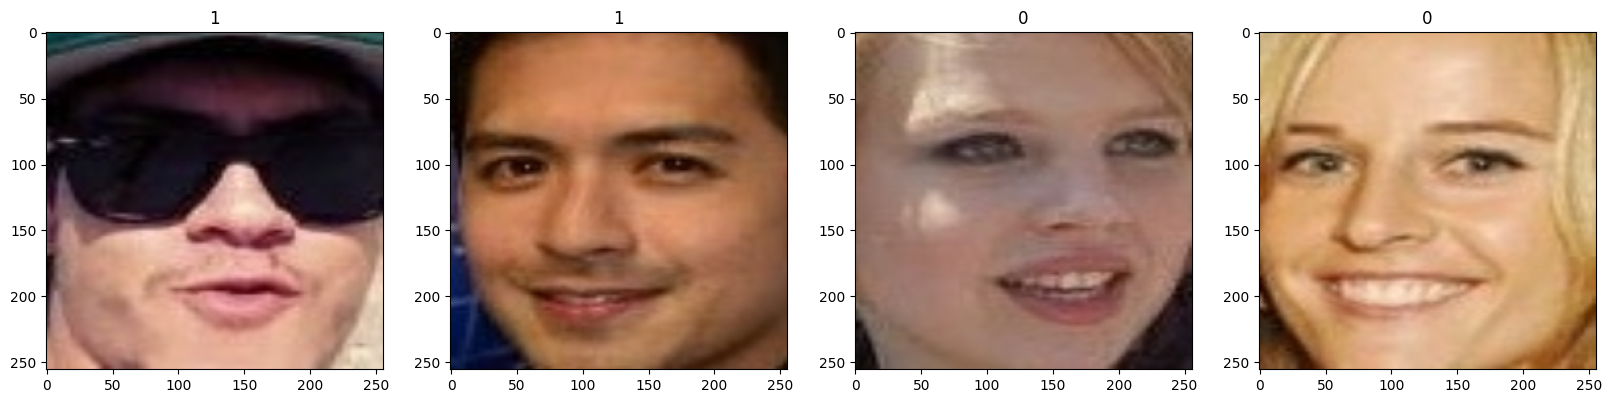

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    #ax[idx].imshow(img.astype(int))
    ax[idx].set_title(batch[1][idx])
    #ax[idx].title.set_text(batch[1][idx])

In [15]:
print('Data batches: ',len(data)) #number of batches of data
print('Validation data batches: ',len(validation)) #number of batches of validation data

Data batches:  1470
Validation data batches:  365


In [16]:
#making training, validation and test sets.
train_size = len(data)
val_size = int(0.8 * len(validation))
test_size = int(0.2 * len(validation))
print(val_size)
train = data.take(train_size) # type: ignore
val = validation.take(val_size) # type: ignore
test = validation.skip(val_size).take(test_size) # type: ignore

292


In [17]:
#building the model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [19]:
#training the model
logdir = 'logs'
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
early_stopping = EarlyStopping(monitor="val_loss", patience=5)
#hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[early_stopping])

Epoch 1/40


2023-08-04 11:05:47.441227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [47009]
	 [[{{node Placeholder/_4}}]]
2023-08-04 11:05:47.441463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [47009]
	 [[{{node Placeholder/_4}}]]
2023-08-04 11:05:49.540520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-04 11:05:50.801214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-04 

1470/1470 [==============================] - ETA: 0s - loss: 0.2620 - accuracy: 0.8944

2023-08-04 11:06:14.867093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [11649]
	 [[{{node Placeholder/_4}}]]
2023-08-04 11:06:14.867399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [11649]
	 [[{{node Placeholder/_4}}]]


1470/1470 [==============================] - 52s 31ms/step - loss: 0.2620 - accuracy: 0.8944 - val_loss: 0.2505 - val_accuracy: 0.8968
Epoch 2/40
1470/1470 [==============================] - 24s 17ms/step - loss: 0.1643 - accuracy: 0.9384 - val_loss: 0.1504 - val_accuracy: 0.9433
Epoch 3/40
1470/1470 [==============================] - 24s 16ms/step - loss: 0.1257 - accuracy: 0.9548 - val_loss: 0.1306 - val_accuracy: 0.9529
Epoch 4/40
1470/1470 [==============================] - 24s 16ms/step - loss: 0.0981 - accuracy: 0.9650 - val_loss: 0.1549 - val_accuracy: 0.9491
Epoch 5/40
1470/1470 [==============================] - 24s 16ms/step - loss: 0.0716 - accuracy: 0.9748 - val_loss: 0.1771 - val_accuracy: 0.9487
Epoch 6/40
1470/1470 [==============================] - 24s 17ms/step - loss: 0.0495 - accuracy: 0.9832 - val_loss: 0.2037 - val_accuracy: 0.9462
Epoch 7/40
1470/1470 [==============================] - 25s 17ms/step - loss: 0.0391 - accuracy: 0.9861 - val_loss: 0.2397 - val_accura

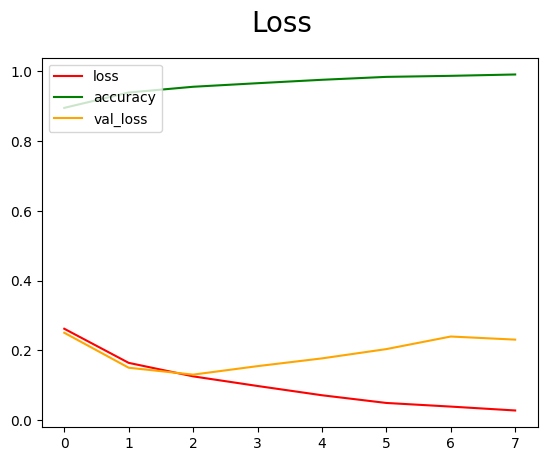

In [20]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='loss')
plt.plot(hist.history['accuracy'], color='green', label='accuracy')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

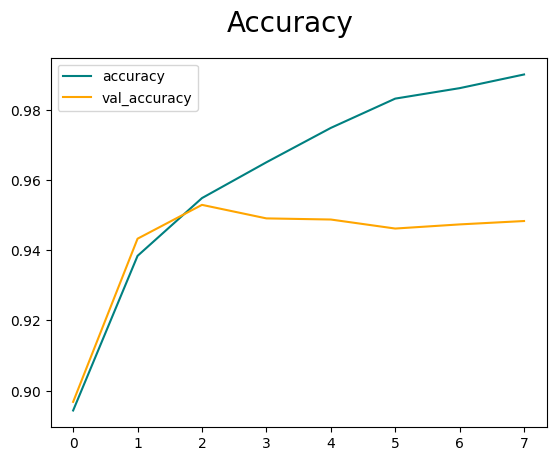

In [21]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [22]:
#Evaluate the model performance
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy # type: ignore
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
len(test)

73

In [23]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

2023-08-04 11:14:14.843673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [11649]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:14:14.843940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [11649]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 40ms/step


In [24]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.9372881650924683, Recall: 0.9559204578399658, Accuracy: 0.9457700848579407


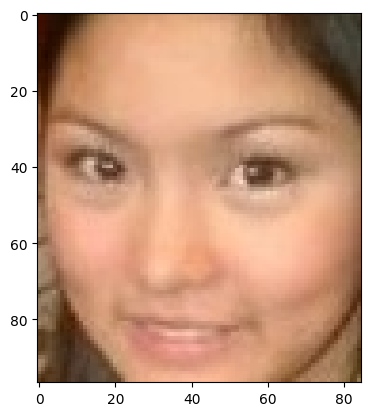

In [25]:
#Test the model
img = cv2.imread('ftest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

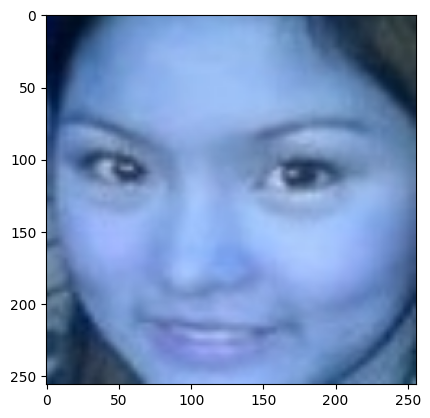

In [26]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int)) # type: ignore
plt.show()

In [27]:
np.expand_dims(resize, 0).shape
yhat = model.predict(np.expand_dims(resize/255, 0)) # type: ignore
print(yhat)
if yhat>0.5:
    print('prediction: Male')
else:
    print('prediction: Female')

1/1 [==============================] - 0s 12ms/step
[[0.00242654]]
prediction: Female


In [28]:
#Save the model for future use.
from tensorflow.keras.models import load_model  # type: ignore
model.save(os.path.join('models','gender_classifier.h5'))

In [29]:
#Load the saved model
new_model = load_model(os.path.join('models','gender_classifier.h5'))
yhatnew = new_model.predict(np.expand_dims(resize/255, 0)) # type: ignore
if yhat>0.5:
    print('prediction: Male')
else:
    print('prediction: Female')

1/1 [==============================] - 0s 40ms/step
prediction: Female
